#### **Imports**

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics


In [2]:
import seaborn as sns
sns.set()

#### **Define the Energy Model**

In [3]:
### class to generate BAS dataset of arbitrary gridsize.
from itertools import permutations, product
class bas_dataset:
    def __init__(self, grid_size:int):
        self.grid_size=grid_size
        all_combn=[''.join(p) for p in product('01',repeat=self.grid_size)]
        all_combn.sort(key=lambda s: s.count('1'))
        all_combn.pop(0);all_combn.pop(-1)
        self.__all_combn=all_combn
        self.bas_dict=self.bars_and_stripes_dataset()
        self.dataset=self.bas_dict['stripes']+self.bas_dict['bars']
    
    def vertical_stripes(self):
        vert_stripes=[j*self.grid_size for j in self.__all_combn]
        return vert_stripes

    def horizontal_bars(self):
        hor_bars=[]
        for l in self.__all_combn:
            st=""
            for j in l:
                st=st+j*self.grid_size
            hor_bars.append(st)
        return hor_bars

    def bars_and_stripes_dataset(self):
        bas_dict={'stripes':self.vertical_stripes(),
            'bars':self.horizontal_bars()}
        return bas_dict

    ### create matrix of bitstring: meant for plotting
    def bit_string_to_2d_matrix(self,bitstring, array_shape:int):
        len_bs=len(bitstring)
        list_bs_int=[eval(i) for i in list(bitstring)]
        arr_bs=np.reshape(list_bs_int,(array_shape, array_shape))
        return arr_bs

    ### plot pixels
    def draw_pixelplot(self,bitstring:str,array_shape:int):
        im_array=self.bit_string_to_2d_matrix(bitstring,array_shape)
        plt.title(f"pixel plot for bitstring: {bitstring}")
        pixel_plot=plt.imshow(im_array,cmap='Greens',interpolation='nearest')
        plt.colorbar(pixel_plot)
        plt.show()

In [4]:
def hebbing_learning(list_bas_state:list):
    size=len(list_bas_state[0])
    wts=0
    for i in list_bas_state:
        arr=np.array([-1 if elem == "0" else 1 for elem in i])
        array=np.reshape(arr,(size,1));array_t=np.transpose(array)
        wts+=array@array_t
    wts=wts-len(list_bas_state)*np.identity(size)
    return wts

In [5]:
gridsize=3
bas=bas_dataset(grid_size=gridsize)
wt=hebbing_learning(bas.dataset)
# np.shape(wt);wt

In [6]:
bas.bas_dict

{'stripes': ['001001001',
  '010010010',
  '100100100',
  '011011011',
  '101101101',
  '110110110'],
 'bars': ['000000111',
  '000111000',
  '111000000',
  '000111111',
  '111000111',
  '111111000']}

In [7]:
# define the model
np.random.seed(610358)# should always be in the same cell!  ## best seed -> 610358
n_spins = 6

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )
J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

#evaluating J for BAS dataset
#J=-1*wt#np.array([[0,0,0,4],[0,0,4,0],[0,4,0,0],[4,0,0,0]])
# defining h
#h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)
#h=np.zeros(np.shape(J)[0])
# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')
#model=IsingEnergyFunction(J,h,name=f"BAS data of gridsize {np.shape(J)[0]}")

In [8]:
hamilt_check=model.get_hamiltonian()
hamilt_check.get_matrix().toarray()

array([[ 4.048+0.j,  0.   +0.j,  0.   +0.j, ...,  0.   +0.j,  0.   +0.j,
         0.   +0.j],
       [ 0.   +0.j,  0.818+0.j,  0.   +0.j, ...,  0.   +0.j,  0.   +0.j,
         0.   +0.j],
       [ 0.   +0.j,  0.   +0.j,  3.612+0.j, ...,  0.   +0.j,  0.   +0.j,
         0.   +0.j],
       ...,
       [ 0.   +0.j,  0.   +0.j,  0.   +0.j, ..., -1.408+0.j,  0.   +0.j,
         0.   +0.j],
       [ 0.   +0.j,  0.   +0.j,  0.   +0.j, ...,  0.   +0.j, -4.962+0.j,
         0.   +0.j],
       [ 0.   +0.j,  0.   +0.j,  0.   +0.j, ...,  0.   +0.j,  0.   +0.j,
        -3.132+0.j]])

In [9]:
model.get_J

array([[ 0.   , -0.416, -1.051,  1.003,  0.361,  1.368],
       [-0.416,  0.   ,  0.264, -0.896,  0.676,  0.05 ],
       [-1.051,  0.264,  0.   , -0.431, -0.652,  0.335],
       [ 1.003, -0.896, -0.431,  0.   , -0.631, -1.152],
       [ 0.361,  0.676, -0.652, -0.631,  0.   ,  1.63 ],
       [ 1.368,  0.05 ,  0.335, -1.152,  1.63 ,  0.   ]])

            MODEL : my_model
Non-zero Interactions (J) : 15 / 15
Non-zero Bias (h) : 6 / 6
---------------------------------------------
Average Interaction Strength <|J|> :  0.6064444444444445
Average Bias Strength <|h|>:  0.5983333333333333
alpha :  0.668089629339876
---------------------------------------------


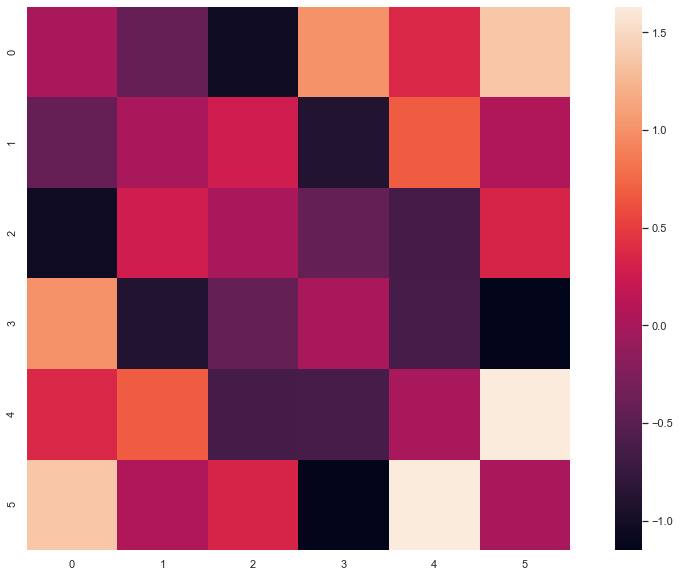

In [10]:
model.model_summary()

In [11]:
## checking qulacs fn_qc_h1 term.
# from qulacs.gate import Pauli,X
# gate_x=X(2)
# print("gate_x:")
# print(gate_x.get_matrix())
# target_list=[2]
# pauli_index=[1]
# gate_2=Pauli(target_list,pauli_index)
# print("gate_2")
# print(gate_2.get_matrix())
# # these two are the same thing
# multi_x_gate=Pauli([0,1],[2,1])
# print("multi_x_gate")
# print(multi_x_gate.get_matrix())

#### **Exact Analysis**

In [12]:
## set current beta
beta = 1#1.100209

## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

In [13]:
bas.dataset.sort()
bas.dataset,len(bas.dataset)

(['000000111',
  '000111000',
  '000111111',
  '001001001',
  '010010010',
  '011011011',
  '100100100',
  '101101101',
  '110110110',
  '111000000',
  '111000111',
  '111111000'],
 12)

     MODEL : my_model |  beta : 1
Num Most Probable States : 10
Entropy : 2.7636942863645784
---------------------------------------------


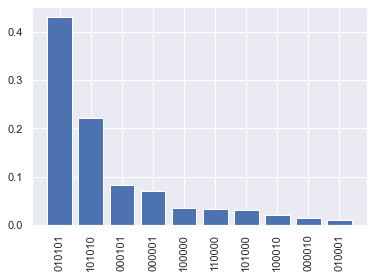

In [14]:
## get the distribution from model
bpd = exact_sampled_model.boltzmann_pd

## exact sampling summary
exact_sampled_model.sampling_summary()

#### **Run Classical MCMC**

In [15]:
steps = 5000
cl_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    # return_last_n_states=10,
    temperature=1/beta,
)

In [16]:
cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)

#### **Run Quantum Enhaned MCMC**

In [17]:
from qumcmc.quantum_mcmc_routines_qulacs_exact import create_X_mixer_hamiltonian

In [18]:
H_mix=create_X_mixer_hamiltonian(num_spins=n_spins,weight_individual_pauli=1)

type_mixer_hamiltonian: <class 'qulacs_core.Observable'>
list_individual_terms:
['X 0 ', 'X 1 ', 'X 2 ', 'X 3 ', 'X 4 ', 'X 5 ']


In [19]:
np.shape(H_mix.get_matrix().toarray()), np.shape(model.get_hamiltonian().get_matrix().toarray())

((64, 64), (64, 64))

In [20]:
type(1), type(np.random.choice(list(range(2,12)))), type(float(np.round(np.random.uniform(low= 0.2, high = 0.6 ), decimals=6)))

(int, numpy.int32, float)

In [21]:
type(model.num_spins)

int

In [22]:
steps = 5000
qamcmc_chain_1 =quantum_mcmc_exact(n_hops=steps,
                                   model=model,                                   
                                   H_mix=H_mix,
                                   gamma_range=(0.2,0.6)
                                   )

In [23]:
# steps = 5000
# qamcmc_chain_1 =quantum_enhanced_mcmc(
#     n_hops=steps,
#     model=model,
#     temperature=1/beta
# )

In [24]:
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc

In [25]:
steps =5000
qamcmc_chain_2 =quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta
)

In [26]:
qumcm1_statistic = get_trajectory_statistics(qamcmc_chain_1, exact_sampled_model, verbose= False)
qumcm2_statistic = get_trajectory_statistics(qamcmc_chain_2, exact_sampled_model, verbose= False)

#### **Sampled Distributions**

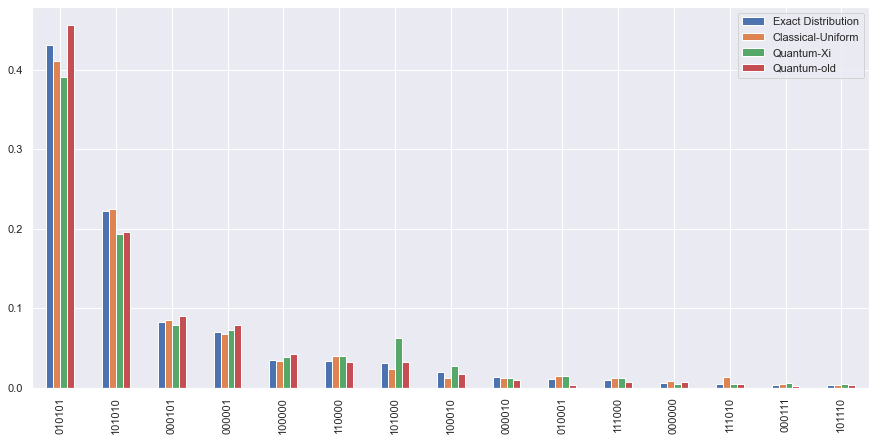

In [27]:
distributions_to_plot = [exact_sampled_model.boltzmann_pd, cl_chain.get_accepted_dict(normalize= True), 
                        qamcmc_chain_1.get_accepted_dict(normalize= True),qamcmc_chain_2.get_accepted_dict(normalize= True) ]
plot_multiple_bargraphs(distributions_to_plot, ['Exact Distribution', 'Classical-Uniform', 'Quantum-Xi','Quantum-old'], list_normalise= [False, False, False,False], plot_first_few=15)

#### **Proposition Strategy Analysis**

Here we analyse the main adavnatge of the Quantum Enhanced MCMC routine, which is to propose transitions which are are more likely to be accepted when compared to usual classical proposition strategies. In the subsequent plots we compare statistics of all proposed transitions with respect to the *Acceptance-Probabilities* , *Energy-Difference*, and the *Hamming-Distance*.

**Acceptance-Probabilities**


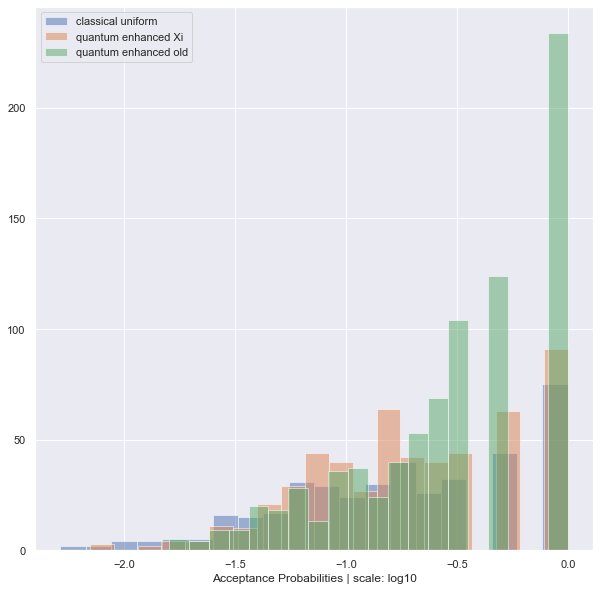

In [28]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.5, bins= 20)
plt.hist(np.log10(qumcm1_statistic['acceptance_prob']),label= 'quantum enhanced Xi' , alpha= 0.5, bins= 20)
plt.hist(np.log10(qumcm2_statistic['acceptance_prob']),label= 'quantum enhanced old' , alpha= 0.5, bins= 20)



# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

The plot depicts that the *Acceptance-Probability* for the *quantum-enhanced* sampling is skewed towards unity, whereas for the *classical-uniform* sampling it is barely close to unity for most of th cases leading to a large rejection rate of the proposed moves.

**Energy-Difference**

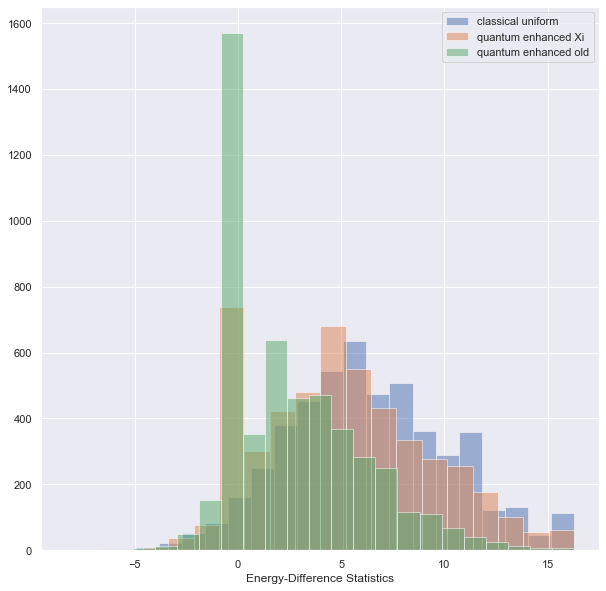

In [29]:
plt.figure(figsize=(10,10))

plt.hist(cl_statistic['energy'],label= 'classical uniform' ,alpha= 0.5, bins= 20)
plt.hist(qumcm1_statistic['energy'],label= 'quantum enhanced Xi' , alpha= 0.5, bins= 20)
plt.hist(qumcm2_statistic['energy'],label= 'quantum enhanced old' , alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Energy-Difference Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

The plot shows that the *Energy-Difference* of the propose transitions is low for the case of *quantum-enhanced* transitions compared to the *classical-uniform* sampling, this also explains the trend in *Acceptance-Probability* as it is directly dependent on the former.


**Hamming-Distance**

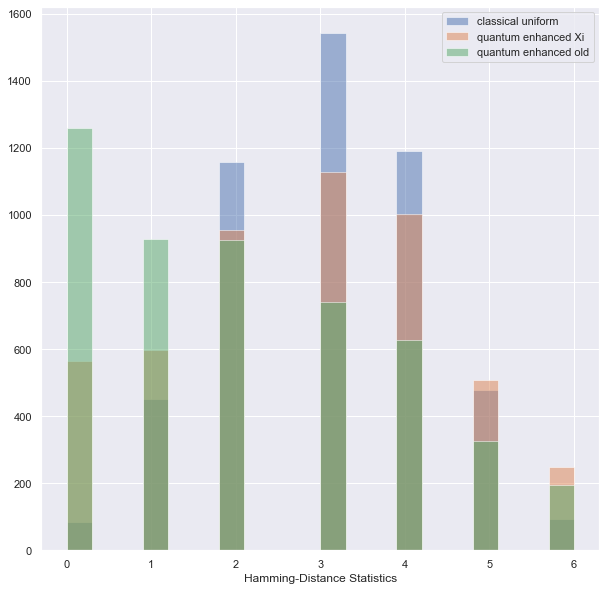

In [30]:
plt.figure(figsize=(10,10))

plt.hist(cl_statistic['hamming'],label= 'classical uniform' ,alpha= 0.5, bins= 20)
plt.hist(qumcm1_statistic['hamming'],label= 'quantum enhanced Xi' , alpha= 0.5, bins= 20)
plt.hist(qumcm2_statistic['hamming'],label= 'quantum enhanced old' , alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Hamming-Distance Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

#### **Convergence Analysis**

##### Magnetisation

In [31]:
# magnetization_model = exact_sampled_model.get_observable_expectation(magnetization_of_state)
# magnetization_c = calculate_runnning_magnetisation(cl_chain)
# magnetization_q = calculate_runnning_magnetisation(qamcmc_chain)

In [32]:
# plt.figure(figsize=(10,8))
# plt.plot(magnetization_c, label= 'classical-uniform')
# plt.plot(magnetization_q, label= 'quantum-enhanced')
# plt.axhline(magnetization_model, label= 'original')
# plt.xlabel("iterations")
# plt.ylabel("magnetisation")
# plt.legend()
# plt.show()

##### KL Divergence

In [33]:
kldiv_c = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, cl_chain)
kldiv_q1 = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain_1)
kldiv_q2 = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain_2)

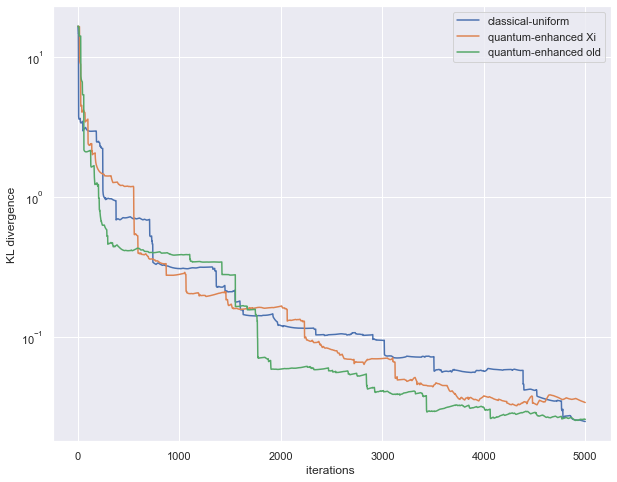

In [34]:
plt.figure(figsize=(10,8))
plt.plot(kldiv_c, label= 'classical-uniform')
plt.plot(kldiv_q1, label= 'quantum-enhanced Xi')
plt.plot(kldiv_q2, label= 'quantum-enhanced old')
plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()

In [35]:
# from qulacs import PauliOperator
# Pauli_string='Z 0 I 1'
# pauli_check=PauliOperator(Pauli_string,coef=1)

In [36]:
# pauli_check.get_pauli_id_list()

In [37]:
# from qulacs.gate import merge,Identity,Z

In [38]:
# gate_Z0_I1=merge([Z(2),Identity(1)])

In [39]:
# gate_Z0_I1.get_matrix()

In [40]:
# gate_Z0_I1.get_matrix()

In [41]:
# Z(0).get_matrix(),Z(2).get_matrix()

In [42]:
# # qulacs imports
# from qulacs import QuantumState, QuantumCircuit
# from qulacsvis import circuit_drawer
# from scipy.linalg import expm
# from qulacs.gate import DenseMatrix
# from qulacs.gate import X, Y, Z  , Pauli, Identity, merge